# Sensitivity Analysis Plots

In this tutorial, we'll generate Quantized Tensor Histogram (QTH) + Sensitivity Analysis (SA) plots for a quantized ResNet model. What's the point of these? Well, QTH is a type of plot that shows how a tensor is distributed, on top of the quantization grid, for whatever layer one wishes. This is useful if you want to see how your data is distributed with respect to your quantization grid, for either weights or activations. This can give you insight into whether your quantization grid makes sense or not, if you're suffering from twin-tower issues, etc.

Cool, but what about the SA? Well, seeing how the data is distributed on the quantization grid is great, but it's not always the most informative thing. Let's take an activation as an example. The QTH may tell you that your data is distributed in a certain way across the quantization grid. We see both rounding quantization error, and clamping quantization error. But how do you know which matters the most, or do both of them?

The idea behind SA is to backpropagate the output of the model, without any manipulation of the loss function. We can then interpret the gradients as representing the contribution, i.e. the "importance", of each quantization bin to the output of the model. This tells us how much each quantization bin, for both activations and weights, contributed to the output of the model given the input data. This gives us some more insight into how our model operates, and into what kind of quantization grid we should be aiming for.

Below is an example we will generate over the course of this tutorial. It represents the last requantization step activation from a FX quantized ResNet model that was fed the image of a dog. The blue represents the forward activation, but the green represents the gradients. 
If we were only looking at the forward pass, we might assume that some of the negative elements of the quantization grid are informative. 
However, observing the gradients shows us that mainly only the positive elements of this layer actually contribute to the final output of the model. Therefore, we might want to prioritise assigning more reoslution to the positive elements of the activation, at the expense of the negative values. That is, at far as this image of a dapper Samoyed is concerned.

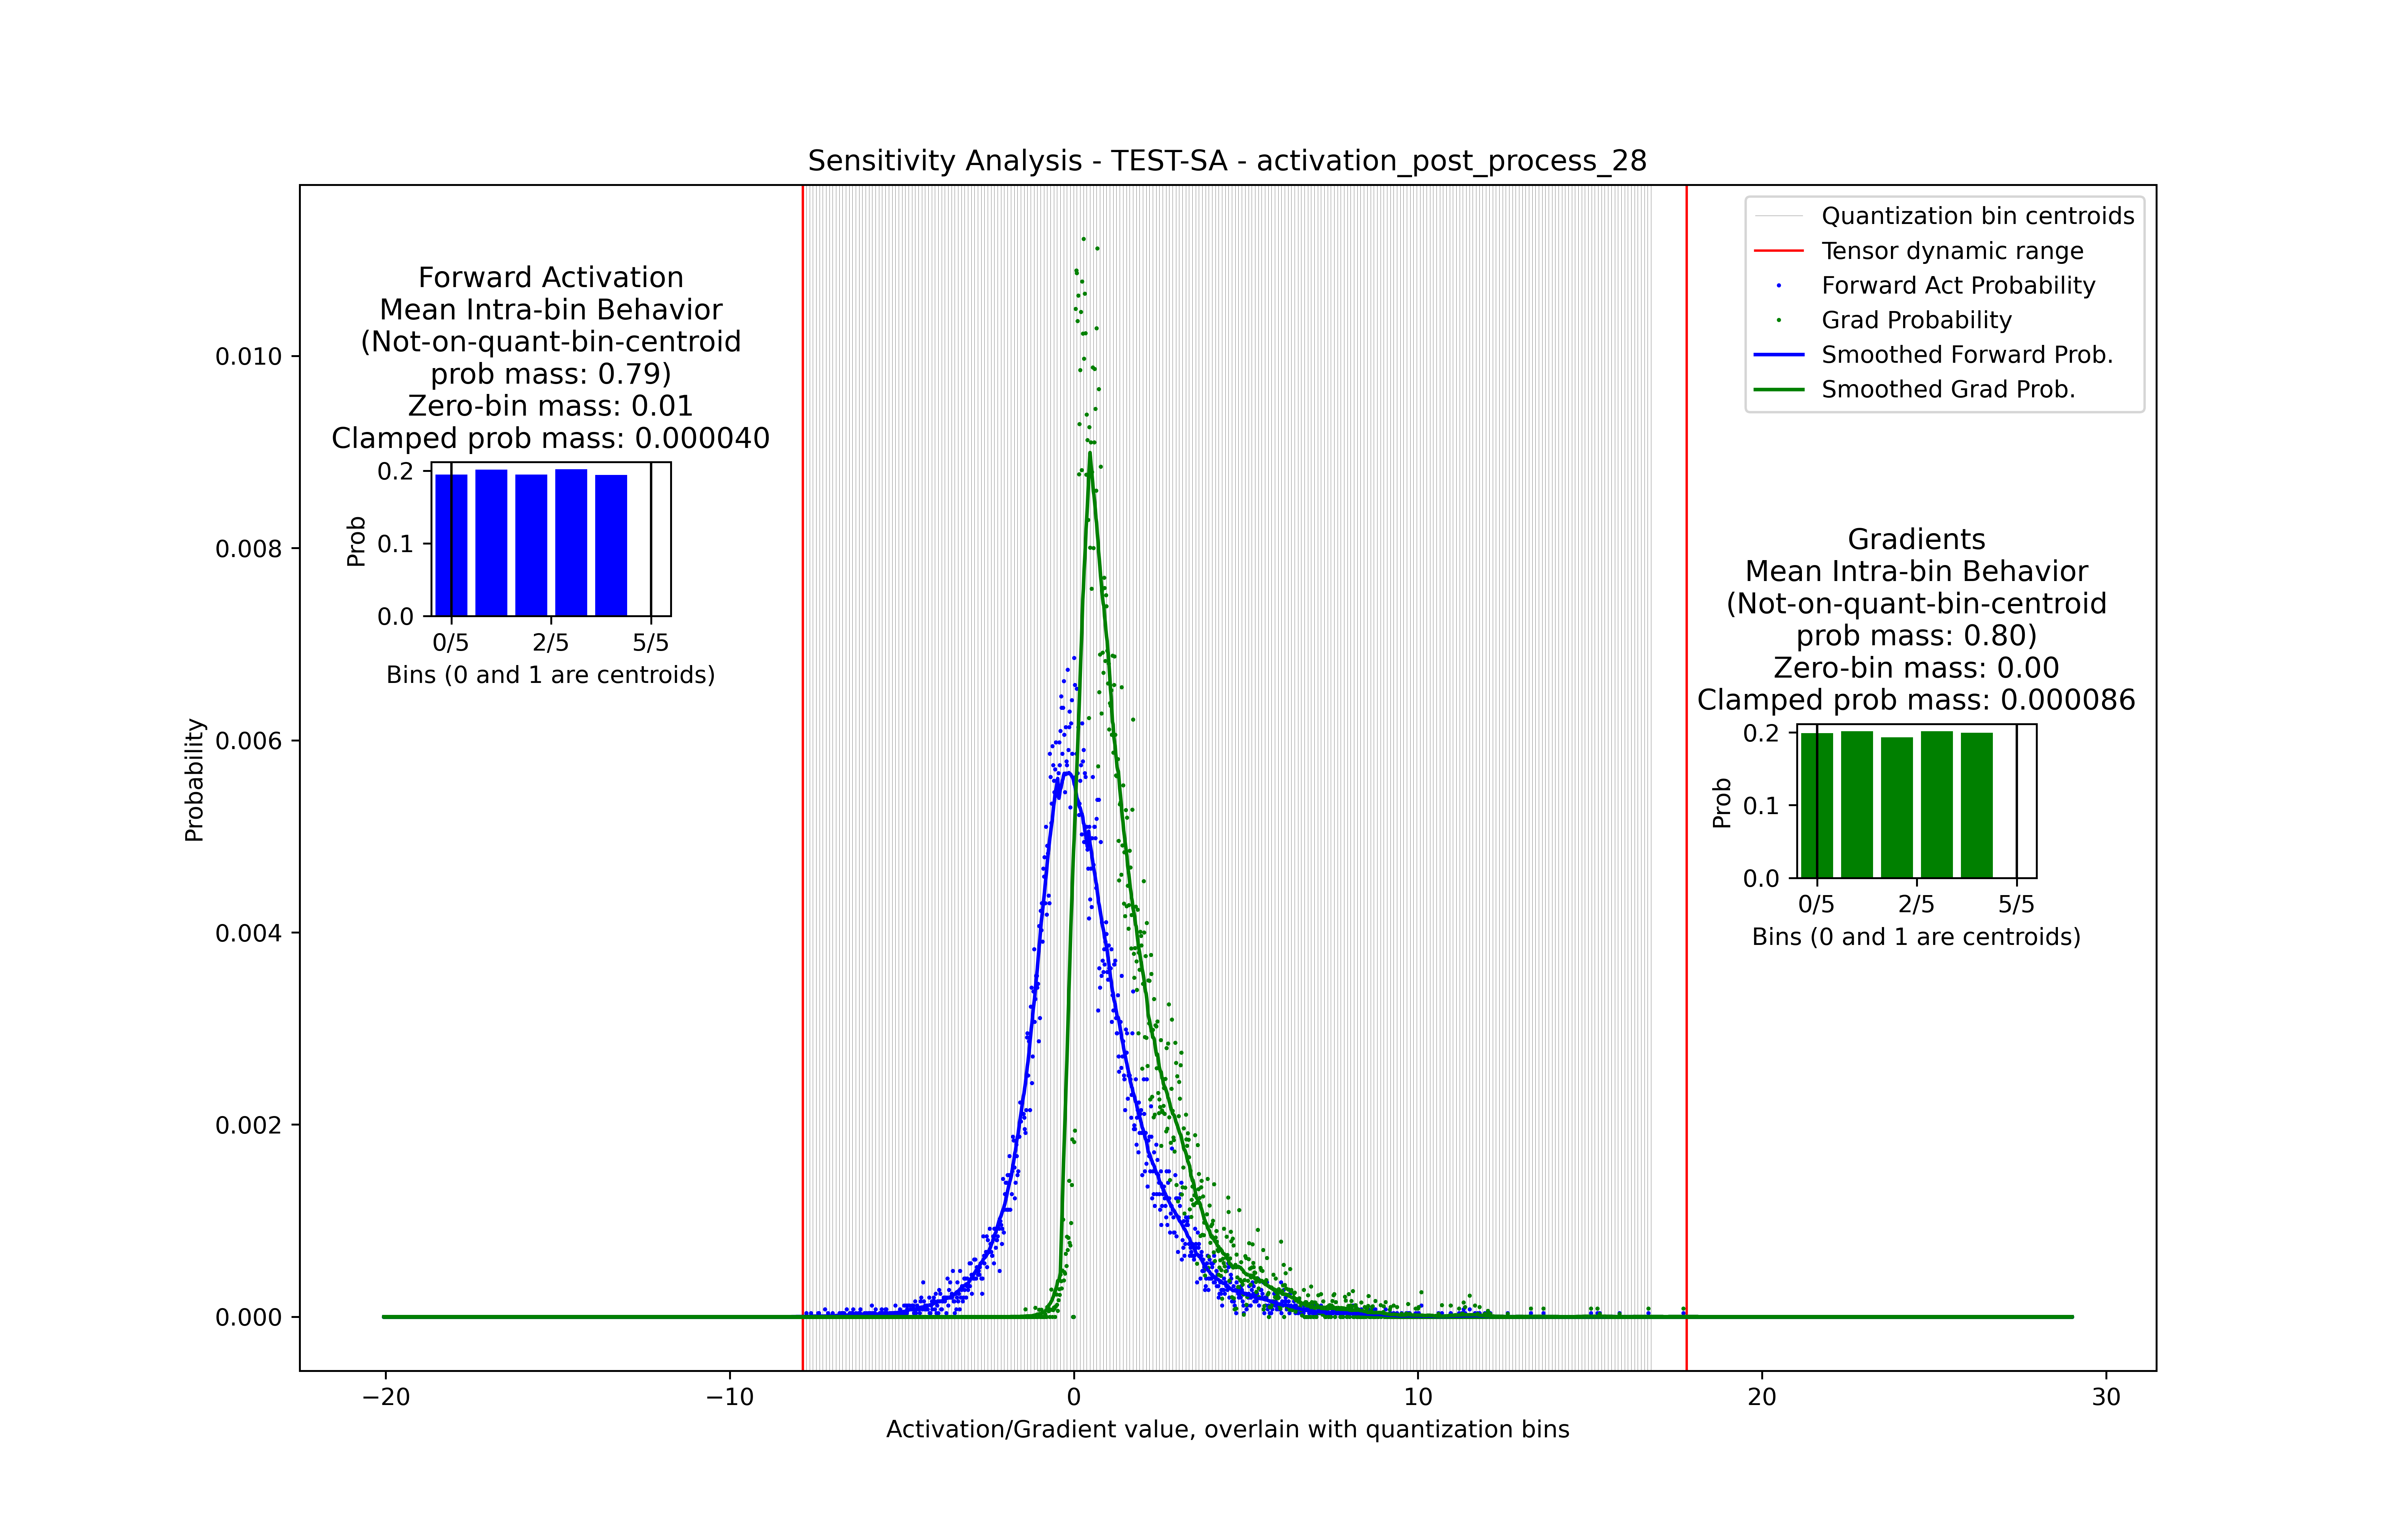

In [1]:
!pip install torch torchvision

## WARNING: 
You will have to run:
```
pip install -e .
```
from the home directory, or otherwise have EasyQuant installed, for this notebook to work.

In [2]:
import torch
import torch.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx
from torch.ao.quantization.qconfig_mapping import QConfigMapping

from pathlib import Path

from quant_modules.state_toggling import (
    enable_fake_quant,
    enable_PTQ_observer,
    disable_fake_quant,
    disable_PTQ_observer,
)
from quant_modules.learnable_fake_quantize import (
    EQLearnableFakeQuantize
)
from quant_vis.histograms import (
    plot_quant_act_hist,
    plot_quant_weight_hist,
    plot_quant_act_SA_hist,
    add_sensitivity_analysis_hooks,
    add_activation_forward_hooks,
)

We initialise the ResNet model, used for this example.

In [3]:
from tests.model.resnet import resnet18
model = resnet18(weights="ResNet18_Weights.DEFAULT")

## Quantizing the model
For the qconfigs, we use EasyQuant Learnable Fake Quantize quantization modules for both weights and activations, with affine per tensor quantization for activations and per-channel symmetric quantization for weights. Feel free to use any quantization modules you wish, it won't matter for this tutorial (but EasyQuant ones are about 50% faster than native PyTorch ones on 4090s).

In [4]:
learnable_weight = lambda channels: EQLearnableFakeQuantize.with_args(
    observer=tq.PerChannelMinMaxObserver,
    quant_min=-128,
    quant_max=127,
    dtype=torch.qint8,
    qscheme=torch.per_channel_symmetric,
    scale=0.1,
    zero_point=0.0,
    use_grad_scaling=True,
    channel_len=channels,
)

learnable_act = EQLearnableFakeQuantize.with_args(
    observer=tq.HistogramObserver,
    quant_min=0,
    quant_max=255,
    dtype=torch.quint8,
    qscheme=torch.per_tensor_affine,
    scale=1.0,
    zero_point=0.0,
    use_grad_scaling=True,
)

We assign the qconfigs. The only reason we need the for loop is so that we can have per-channel learnable qparams for the weights, as the quantization module needs to be initialised with the correct number of output channels for the module.

In [5]:
torch.backends.quantized.engine = "fbgemm"
qconfig_mapping = QConfigMapping()
# NOTE: It's worth noting that including the following (commented out) lines in the qconfig mapping caused some issues in 
# backpropagating: the backpropped gradients didn't match the size of the forward activations, which was bizarre.
#.set_global(
    #tq.QConfig(activation=learnable_act, weight=tq.default_fused_per_channel_wt_fake_quant)
#)
for name, module in model.named_modules():
    if hasattr(module, "out_channels"):
        qconfig = tq.QConfig(
            activation=learnable_act,
            weight=learnable_weight(channels=module.out_channels),
        )
        qconfig_mapping.set_module_name(name, qconfig)
        module.qconfig = qconfig

Once that's all done, we can just feed some random data through the model to do the symbolic trace, and quantize the model. PyTorch takes care of all of this under the hood in the `prepare_qat_fx` API.

In [6]:
example_inputs = (torch.randn(1, 3, 224, 224),)
model.eval()
fx_model = prepare_qat_fx(model, qconfig_mapping, example_inputs)

In the FX quantized ResNet model, the BatchNorm layers are not fused into the Convs. This is because the `prepare_qat_fx` API ensures that all "properties" of the model stay the same. However, in this tutorial we are going to want to observe the weight tensors, and that's going to make more sense if we can observe the weight tensor in its final state, and not through the filter of the batchnorm layer. As such, we're going to fuse the BatchNorm layers into the preceding Conv layers.

In [7]:
# Fuse BatchNorms into preceding Conv layers. This makes plotting the
# distribution of weight tensors more interpretable.
from tutorials.SA_plots.fusing_bn_into_conv import convbn_to_conv
fx_model.eval()
fx_model = convbn_to_conv(fx_model)

Next, we can evaluate the quantized model just to make sure everything is fine. We also turn on PTQ so that the qparams are also calibrated. 

In [8]:
from tests.evaluate import evaluate
_ = fx_model.apply(enable_fake_quant)
_ = fx_model.apply(enable_PTQ_observer)

print("\nFX prepared")
fx_model.apply(enable_PTQ_observer)
evaluate(fx_model, 'cpu')


FX prepared

Evaluation:
Samoyed 0.8830579519271851
Arctic fox 0.05734744668006897
white wolf 0.029428191483020782
Pomeranian 0.007522757165133953
Great Pyrenees 0.005933553446084261


## Generating the QTH and SA plots

### Adding hooks
Alright, now we can get to the fun part: get the Quantized Tensor Histograms and Sensitivity Analysis. To do so, we need to add the sensitivity analysis hooks. The forward activation data and hooks are stored in `act_forward_histograms`, and the backwards data and hooks are stored in `act_backward_histograms`.

We also have an optional `conditions_met` callable input (which takes in a module and its name), which can be used to specify which modules should have hooks attached to them. For example (as below), one might want to specify that only `activation_post_process` layers of type `EQLearnableFakeQuantize` with the character `1` in their names should have forward and sensitivity analysis hooks attached. Inside of `add_sensitivity_analysis_hooks`, `conditions_met` will be called on each module, and if the result is `True` then the hook will be added.

It's worth noting we set `bit_res=8`. This only defines the histogram plot resolution, not that of the quantized model. Ideally they should be the same, but we give manual control over this for the plots.

In [9]:
def conditions_met_forward_act_hook(module: torch.nn.Module, name: str) -> bool:
    if isinstance(module, EQLearnableFakeQuantize):
        if '1' in name:
            print(f"Adding hook to {name}")
            return True
    return False

# We don't need to have the observer on anymore, but it doesn't make any difference for the plots
fx_model.apply(disable_PTQ_observer)
# We add the hooks
act_forward_histograms, act_backward_histograms = add_sensitivity_analysis_hooks(
    fx_model, conditions_met=conditions_met_forward_act_hook, bit_res=8
)

WARNING - forward_hooks.py:139 - 
Adding forward activation histogram hooks. This will significantly slow down the forward calls for the targetted modules.


Adding hook to activation_post_process_1
Adding hook to activation_post_process_10
Adding hook to activation_post_process_11
Adding hook to activation_post_process_12
Adding hook to activation_post_process_13
Adding hook to activation_post_process_14
Adding hook to activation_post_process_15
Adding hook to activation_post_process_16
Adding hook to activation_post_process_17
Adding hook to activation_post_process_18
Adding hook to activation_post_process_19
Adding hook to activation_post_process_21


We can see that the hooks have been initialised, with the hook handles for the forwards and backwards calls stored respectively in `act_forward_histogram` and `act_backward_histogram`. These are both `ActHistogram` instances, which is a simple dataclass for storing arbitrary data and hook handles. However, no data has yet been fed through the model so we can see that their `data` attributes are empty.

In [10]:
print(act_forward_histograms)
print(act_backward_histograms)

ActHistogram(data={}, hook_handles={'activation_post_process_1': <torch.utils.hooks.RemovableHandle object at 0x7f4b6141e0c0>, 'activation_post_process_10': <torch.utils.hooks.RemovableHandle object at 0x7f4b62a211c0>, 'activation_post_process_11': <torch.utils.hooks.RemovableHandle object at 0x7f4b614e95e0>, 'activation_post_process_12': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea2a0>, 'activation_post_process_13': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea240>, 'activation_post_process_14': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea120>, 'activation_post_process_15': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea3f0>, 'activation_post_process_16': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea4b0>, 'activation_post_process_17': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea570>, 'activation_post_process_18': <torch.utils.hooks.RemovableHandle object at 0x7f4b614ea660>, 'activation_post_process_19': <torch.utils.ho

### Passing data through the model to populate the histograms
To populate the histograms, one needs to feed data through the model to fill the forward histograms, and then backpropagate it to fill the backwards histograms. Here, we use the evaluation function from `https://pytorch.org/hub/pytorch_vision_resnet/`. It's the same as our `evaluate` function, but we also backpropagate the output.

In [11]:

def forward_and_backprop_an_image(model: torch.nn.Module):
    import urllib
    url, filename = (
        "https://github.com/pytorch/hub/raw/master/images/dog.jpg",
        "dog.jpg",
    )
    try:
        urllib.URLopener().retrieve(url, filename)
    except:
        urllib.request.urlretrieve(url, filename)
    # sample execution (requires torchvision)
    from PIL import Image
    from torchvision import transforms

    input_image = Image.open(filename)
    preprocess = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(
        0
    )  # create a mini-batch as expected by the model
    input_batch.to('cpu')
    model.to('cpu')

    # Feed data through the model
    output = model(input_batch)

    # We backpropagate the gradients. We take the mean of the output, ensuring that
    # we backprop a scalar where all outputs are equally represented.
    output.mean().backward()

forward_and_backprop_an_image(fx_model)

In [12]:
act_backward_histograms

ActHistogram(data={'activation_post_process_21': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_19': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_18': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_17': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_16': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_15': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_14': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_13': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_12': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_11': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_post_process_10': {'binned_grads': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'activation_p

### Generating the plots
Now that the histograms have been filled in, we can plot them. This will automatically reset the `ActHistogram` instances, and remove the hooks.

In [13]:
import os
# Generate the forward and Sensitivity Analysis plots
plot_quant_act_SA_hist(
    act_forward_histograms,
    act_backward_histograms,
    file_path=Path(os.path.abspath("") + "/Histogram_plots"),
    sum_pos_1=[0.18, 0.60, 0.1, 0.1], # location of the first mean intra-bin plot
    sum_pos_2=[0.75, 0.43, 0.1, 0.1],
    plot_title="TEST-SA",
    module_name_mapping=None,
    bit_res=8,  # This should match the quantization resolution. Changing this will not change the model quantization, only the plots.
)

INFO - plot_histograms.py:383 - 
Plotting quantization sensitivity analysis plots for TEST-SA. This can take a long time.


If you didn't want to produce the plots for some reaosn, but still wanted to clear the data and remove the hooks, you can call the `reset` method manually on the `ActHistogram` object, e.g.

In [14]:
act_forward_histograms.reset()
act_backward_histograms.reset()

## Producing just the forward activation histogram plots
We can produce forward activation histograms, independent of the sensitivity analysis. E.g., if one only wanted to plot the forward pass, one could do so. However, at the moment we do not support just plotting the gradients in isolation.

In [15]:
# Add activation hooks
act_forward_histograms = add_activation_forward_hooks(
    fx_model, conditions_met_forward_act_hook
)

# Feed data through the model (no backprop required)
evaluate(fx_model, 'cpu')

# Generate plots
plot_quant_act_hist(
    act_forward_histograms,
    file_path=Path(os.path.abspath("") + "/Histogram_plots"),
    plot_title='Just forward hists',
    module_name_mapping=None,
    sum_pos_1=[0.18, 0.60, 0.1, 0.1], # location of the first mean intra-bin plot
)

WARNING - forward_hooks.py:139 - 
Adding forward activation histogram hooks. This will significantly slow down the forward calls for the targetted modules.


Adding hook to activation_post_process_1
Adding hook to activation_post_process_10
Adding hook to activation_post_process_11
Adding hook to activation_post_process_12
Adding hook to activation_post_process_13
Adding hook to activation_post_process_14
Adding hook to activation_post_process_15
Adding hook to activation_post_process_16
Adding hook to activation_post_process_17
Adding hook to activation_post_process_18
Adding hook to activation_post_process_19
Adding hook to activation_post_process_21


INFO - plot_histograms.py:201 - 
Plotting quantized activation tensor histograms for Just forward hists. This can take a long time.



Evaluation:
Samoyed 0.8830579519271851
Arctic fox 0.05734744668006897
white wolf 0.029428191483020782
Pomeranian 0.007522757165133953
Great Pyrenees 0.005933553446084261


## Producing weight histogram and SA plots

We can also just produce the weight histogram plots. No data is required for these, which makes sense since weights are data-independent.

We set the `conditions_met` callable to be `None`, meaning that all modules pass by default, i.e. all weight tensors will be plotted. However, we set the `module_name_mapping` to replace all `.` instances in the name with `-`. If you observe the weight plot file names, they should have names such as `Weight-hist-layer1-0-conv1.png` instead of `Weight-hist-layer1.0.conv1.png`.

In [16]:
def module_mapping(name: str) -> str:
    return name.replace(".","-")

plot_quant_weight_hist(
    fx_model,
    file_path=Path(os.path.abspath("") + "/Histogram_plots"),
    plot_title='Just weight hists',
    module_name_mapping=module_mapping,
    conditions_met=None,
)

INFO - plot_histograms.py:279 - 
Plotting quantized weight tensor histograms for Just weight hists. This can take a long time.


We can also produce weight histogram plots with the sensitivity analysis with the `sensitivity_analysis` flag, if the weight tensors are first provided gradients. 
To demonstrate this, we first reset all of the gradients from the previous backpropagation, just for the sake of having a working exmaple in one cell. We then create new ones, and plot the weight histograms combined with the Sensitivity Analysis. 
Similarly to the activations, it shows how important each quantization bin is to the output of the model, given the input that produced the gradients.

In [17]:
# Clear gradients with the sake of an otherwised unused optimizer
from torch.optim import Adam
optimizer = Adam(fx_model.parameters(), lr=1)
optimizer.zero_grad()

# Check gradients cleared
for parameter in fx_model.parameters():
    assert parameter.grad is None

# Produce new gradients
forward_and_backprop_an_image(fx_model)

# Check gradients exist
for parameter in fx_model.parameters():
    assert parameter.grad is not None

# Create the weight histogram plots, this time with Sensitivity Analysis plots
plot_quant_weight_hist(
    fx_model,
    file_path=Path(os.path.abspath("") + "/Histogram_plots"),
    plot_title='SA weight hists',
    module_name_mapping=module_mapping,
    conditions_met=None,
    sensitivity_analysis=True, # This flag specifies that we should also do a Sensitivity Analysis
)

INFO - plot_histograms.py:279 - 
Plotting quantized weight tensor histograms for SA weight hists. This can take a long time.


If we look at the weight SA plots, we can see that the weight data may be distributed somewat normally, but the "importance" of the weights for processing the picture of our canine protagonist can follows a less obvious distribution.
For exmaple, for `Histogram_plots/weights/sensitivity_analysis/Weight-hist-layer-4-0-conv2.png`, we see a normal distribution for the weights, but in importance/sensitivity we see a dip for weights near 0, and the sensitivity distribution has noticeably thicker tails.

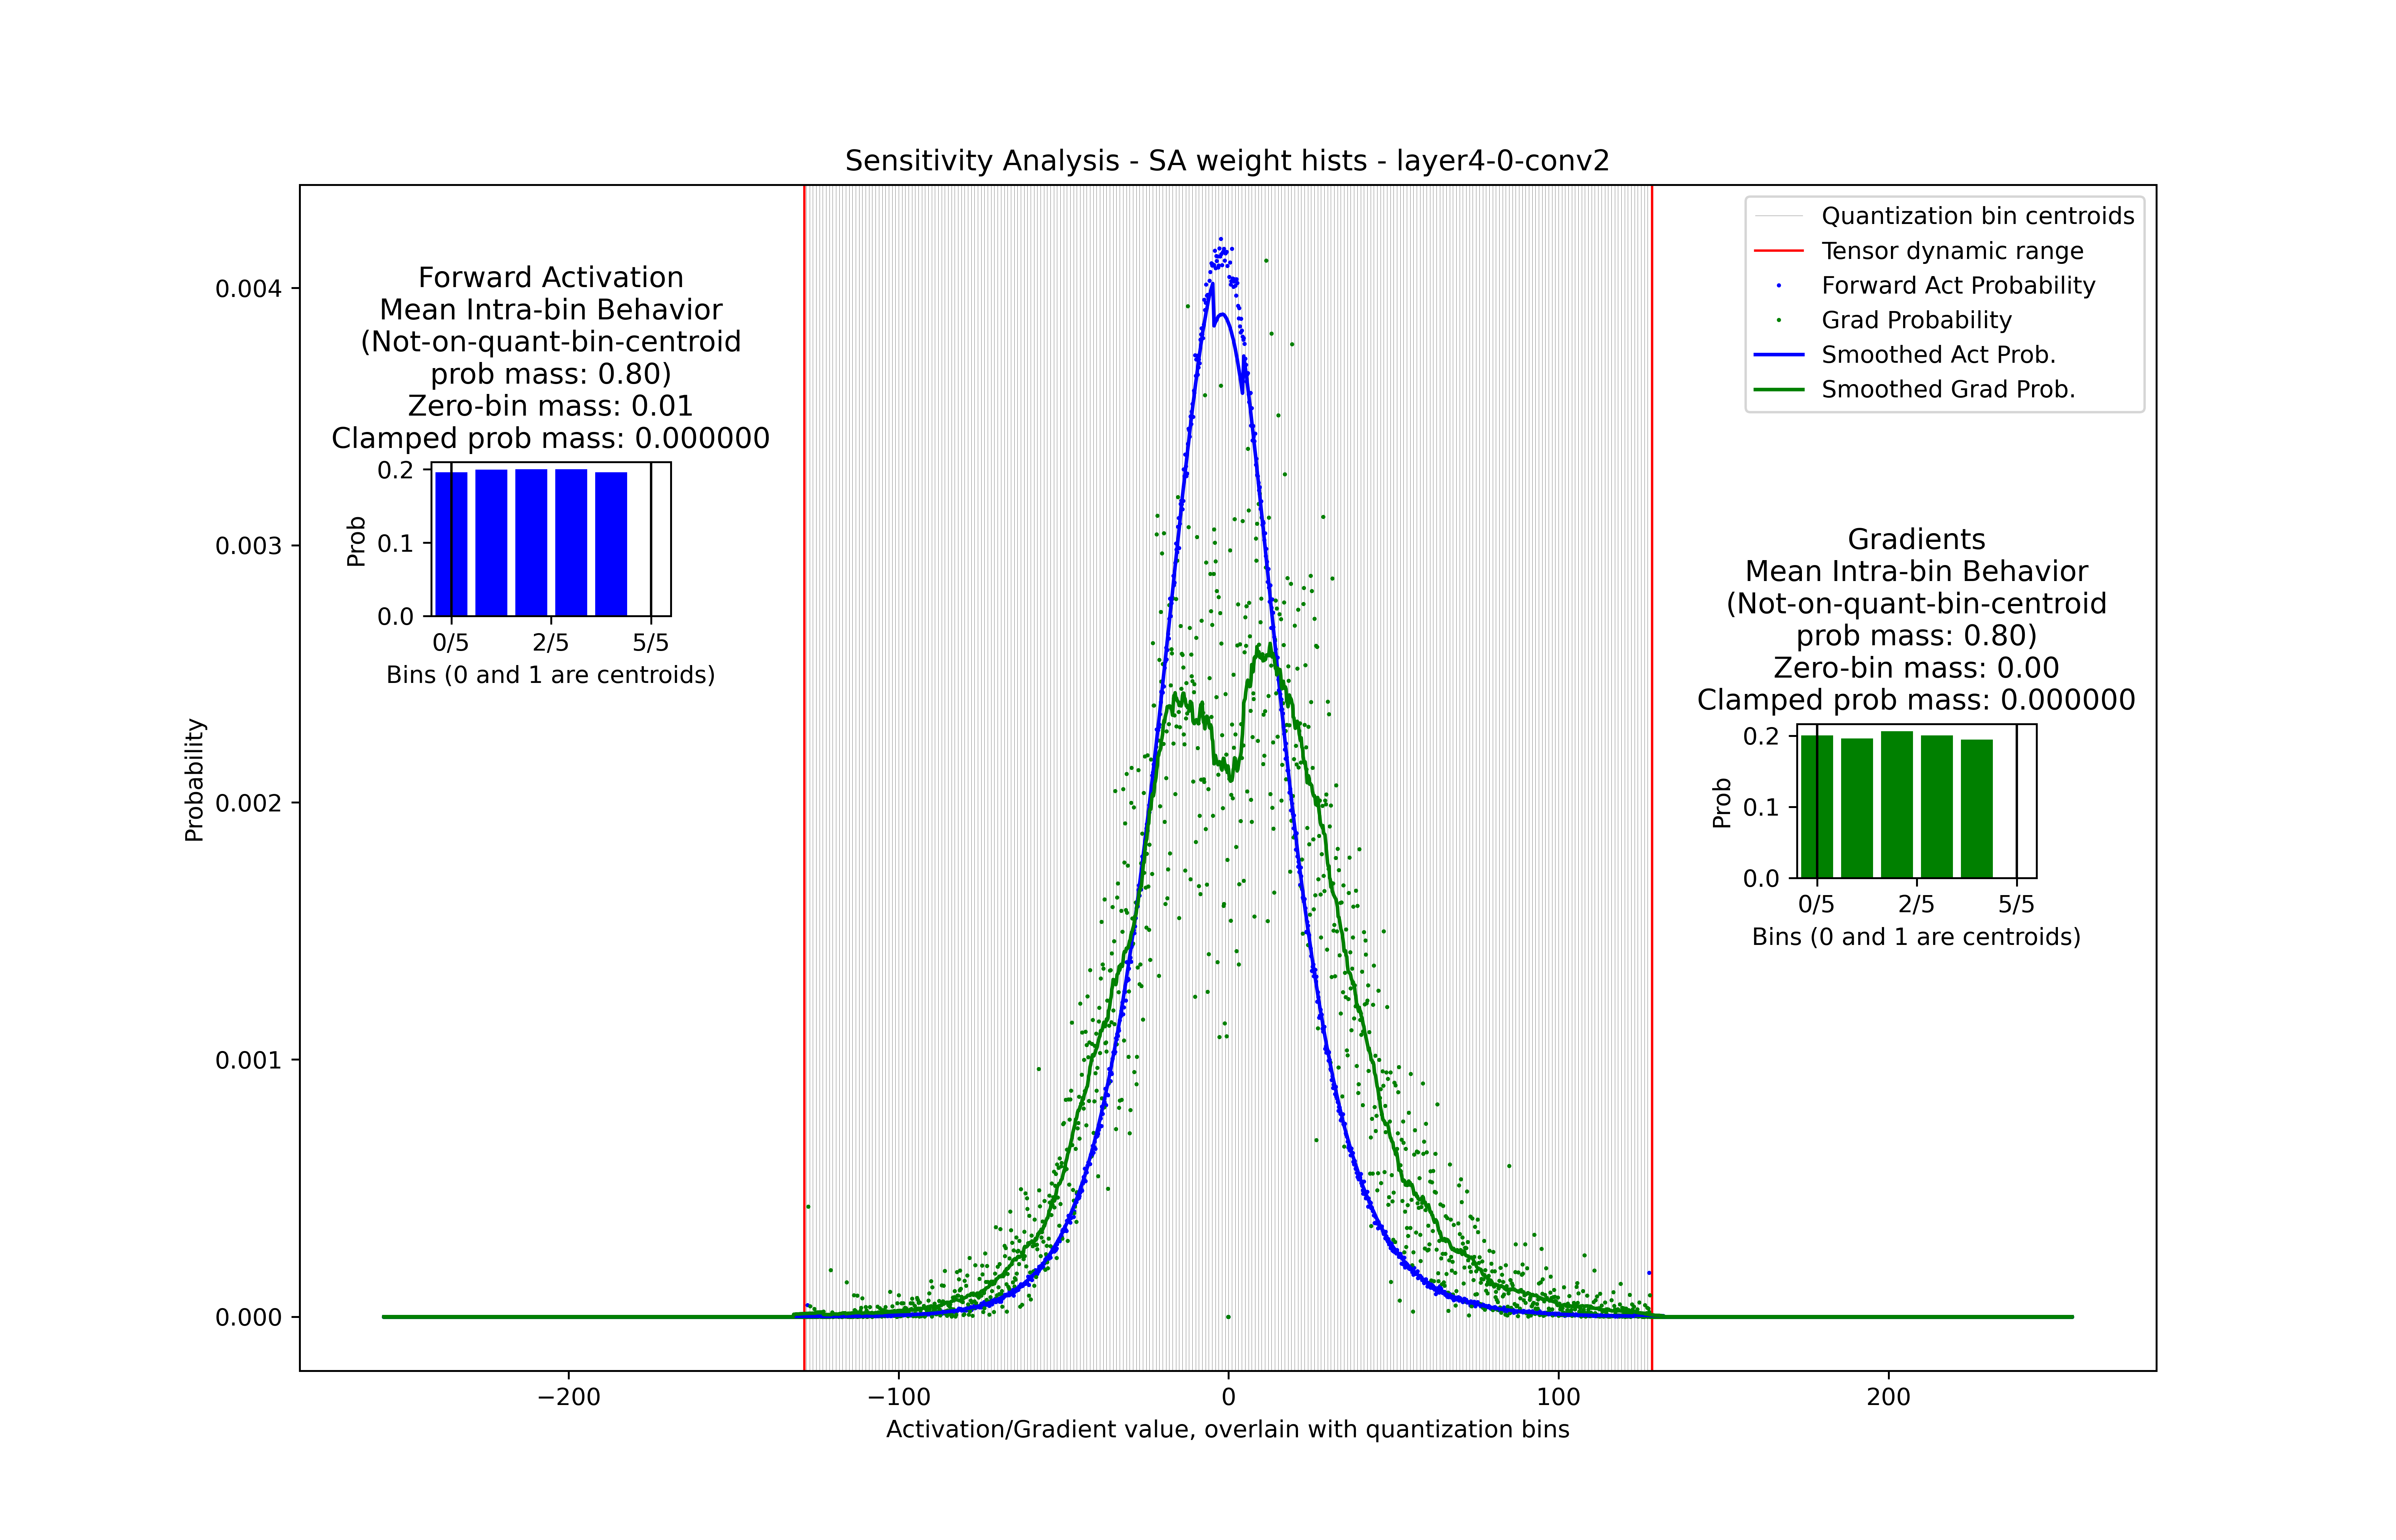